# Load dataset

In [ ]:
import datasets

# google colab

# from google.colab import drive

# drive.mount('/content/drive')

# !unzip "/content/drive/MyDrive/AI/datasets/single character/dataset.zip" -d "/content"
# data = pd.read_csv("/content/drive/MyDrive/AI/datasets/single character/dataset.csv")
# labels = pd.read_csv("/content/drive/MyDrive/AI/datasets/single character/labels.csv")

# !unzip -qq dataset.zip
# ds = datasets.load_from_disk('dataset')

# local
    # handwriting
    
# !unzip -qq dataset.zip
# ds = datasets.load_from_disk('datasets/hand_writing/dataset')

    # latex generated

ds = datasets.load_from_disk('datasets/latex_generated/dataset')    

In [ ]:
import pandas as pd

labels = pd.read_csv('datasets/latex_generated/labels.csv')
label_id = {}
for i, label in enumerate(labels['0']):
    label_id[label] = i

# Resize images

In [ ]:
import numpy as np
import random

def add_random_noise(image):
    noise_type = random.choice(["gaussian", "salt_pepper", "speckle"])
    
    if noise_type == "gaussian":
        mean = 0
        stddev = 1  # Adjust noise level
        gaussian_noise = np.random.normal(mean, stddev, image.shape)
        noisy_image = np.clip(image + gaussian_noise, 0, 1)
    
    elif noise_type == "salt_pepper":
        amount = 0.5  # Adjust noise density
        noisy_image = np.copy(image)
        num_salt = np.ceil(amount * image.size * 0.5).astype(int)
        num_pepper = np.ceil(amount * image.size * 0.5).astype(int)
        
        # Add salt
        coords = [np.random.randint(0, i, num_salt) for i in image.shape]
        noisy_image[coords[0], coords[1]] = 1
        
        # Add pepper
        coords = [np.random.randint(0, i, num_pepper) for i in image.shape]
        noisy_image[coords[0], coords[1]] = 0
    
    elif noise_type == "speckle":
        noise = np.random.randn(*image.shape) * 0.5  # Adjust noise level
        noisy_image = np.clip(image + image * noise, 0, 1)
    
    return noisy_image

In [51]:
import skimage.transform as sk
import numpy as np

new_shape = (40, 40)
def scale_input(data):
    input, output = data['input'], data['label']
    input = sk.resize(np.array(input), new_shape, mode='reflect', anti_aliasing=True)
    input = np.array([[(1 - sum(input[i][j]) / 4) for j in range(new_shape[1])] for i in range(new_shape[0])])
    input = add_random_noise(input)
    output = label_id[output]
    return {'input': input, 'label': output}

train = [scale_input(ds['train'][i]) for i in range(len(ds['train']))]
test = [scale_input(ds['test'][i]) for i in range(len(ds['test']))]

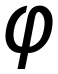

                                        
        @                               
     @  @                               
                o@o     o@@@@@.         
             o@@@@.   o@@@@@@@@@o       
           o@@@@@@   o@@@@@@@@@@@o      
           @@@@@@o  o@@@@@.o@@@@@@o     
        .@@@@@@o   .@@@@@   .@@@@ @.    
       .@@@@@@.    o@@@@.    .@@@@@@    
       @@@@@@      @@@@@      o@@@@@    
      o@@@@@.     .@@@ o      o@@@@@.   
     . @ @@o      .@@@@o      .@@@@@.   
     o@@@@@       o@@@@.      .@@@@@.   
     @@@@@.       @@@@@       .@@@  @   
    .@@@@@        @@@@@       .@@@@@    
    o@@@@o       .@@@@o       o@@@@@    
    @@@@@o       @@@@@.       @@@@@o    
    @@@@@.       @@@@@        @@@@@     
   .@@@@@.      .@@@@@    @  .@@@ o     
   .@@@@@.@     .@@@@o       @@@@@.     
    @@@@@.      o@@@@.      o@@@@@      
    @@@@@o      @@@@@      .@@@@@       
    @@@@@@      @@@@@     .@@@@@.       
   @.@@@@@@    .@@@@o    o@@@@@o        
     o@@@@@@.  o

In [52]:
display(ds['train'][0]['input'])
for r in train[0]['input']:
    for c in r:
        if c < 0.2: print(' ', end='')
        elif c < 0.4: print('.', end='')
        elif c < 0.6: print('o', end='')
        elif c < 0.6: print('O', end='')
        else: print('@', end='')
    print()

# Train

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_channels = 1  # 1 for grayscale, 3 for RGB
image_size = 40
hidden_size = 512
output_size = 229
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)  # (40x40) -> (40x40)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # (40x40) -> (20x20)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # (20x20) -> (20x20)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (20x20) -> (10x10)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # (20x20) -> (20x20)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # (10x10) -> (5x5)

        # Fully connected layers
        self.fc1 = nn.Linear(32*10*10, hidden_size)  # Flattened size
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool3(torch.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))  # Fully connected
        x = self.fc2(x)  # Output layer
        return x

# Initialize model
model = CNN(input_channels, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare dataset (reshape to 40x40 for CNN)
X_train = torch.stack([torch.tensor(data['input'], dtype=torch.float32).reshape(1, image_size, image_size) for data in train]).to(device)
y_train = torch.tensor([data['label'] for data in train], dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test = torch.stack([torch.tensor(data['input'], dtype=torch.float32).reshape(1, image_size, image_size) for data in test]).to(device)
y_test = torch.tensor([data['label'] for data in test], dtype=torch.long).to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = len(test)
        sum_loss = 0

        for i in range(total):
            output = model(X_test[i].unsqueeze(0))  # Add batch dimension
            predicted = torch.argmax(output, dim=1).item()

            if predicted == y_test[i].item():
                correct += 1

            sum_loss += criterion(output, y_test[i].unsqueeze(0)).item()

        avg_loss = sum_loss / total
        accuracy = correct / total

        print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/10], Step [1/157], Loss: 5.4384
Epoch [1/10], Step [101/157], Loss: 0.1146
Epoch 1: Average Loss: 0.0386, Accuracy: 0.9880
Epoch [2/10], Step [1/157], Loss: 0.0838
Epoch [2/10], Step [101/157], Loss: 0.0007
Epoch 2: Average Loss: 0.0026, Accuracy: 1.0000
Epoch [3/10], Step [1/157], Loss: 0.0011
Epoch [3/10], Step [101/157], Loss: 0.0003
Epoch 3: Average Loss: 0.0004, Accuracy: 1.0000
Epoch [4/10], Step [1/157], Loss: 0.0001
Epoch [4/10], Step [101/157], Loss: 0.0025
Epoch 4: Average Loss: 0.0004, Accuracy: 1.0000
Epoch [5/10], Step [1/157], Loss: 0.0001
Epoch [5/10], Step [101/157], Loss: 0.2579
Epoch 5: Average Loss: 0.0184, Accuracy: 0.9910
Epoch [6/10], Step [1/157], Loss: 0.0101
Epoch [6/10], Step [101/157], Loss: 0.0054
Epoch 6: Average Loss: 0.0001, Accuracy: 1.0000
Epoch [7/10], Step [1/157], Loss: 0.0003
Epoch [7/10], Step [101/157], Loss: 0.0001
Epoch 7: Average Loss: 0.0001, Accuracy: 1.0000
Epoch [8/10], Step [1/157], Loss: 0.0001
Epoch [8/10], Step [101/157], Loss: